In [11]:
from data.AI_generated.images.images_dataset1 import df_image1
from data.AI_generated.images.images_dataset2 import df_image2
from data.AI_generated.images.images_dataset3 import df_image3
from data.raw.professions import df_female, df_male
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch


# Analyse: Beobachteter vs. tatsächlicher Genderanteil in Bildern

## Zusammenführen der Datensätze von raw_images_1, raw_images_2, raw_images_3 & Berechnung einiger statistischer Größen
Wir kombinieren alle 3 Bild-Datenframes, um pro Beruf den mittleren Frauen- und Männeranteil zu berechnen.

### Zusammenführen der Datensätze

In [12]:
df_all = pd.concat([df_image1, df_image2, df_image3])

### Berechnung der gewichteten Mittelwerte

In [13]:
df_mean = df_all.groupby("job").agg(
    tot_number_person=("number_person", "sum"),
    tot_number_female=("number_female", "sum"),
    tot_number_male=("number_male", "sum")
).reset_index()

df_mean["tot_percent_female"] = df_mean["tot_number_female"] / df_mean["tot_number_person"] *100
df_mean["tot_percent_male"] = df_mean["tot_number_male"] / df_mean["tot_number_person"] *100

#Füge die Mittelwerte zurück zu df_all (per Merge)
df_all = df_all.merge(
    df_mean[["job", "tot_percent_female", "tot_percent_male"]],
    on="job"
)

### Berechnung der gewichtenen Standardabweichungen

In [14]:
df_all["squared_dev_female"] = ((df_all["percent_female"] - df_all["tot_percent_female"]) ** 2)

df_all["weighted_squared_dev_female"] = (df_all["number_person"] * df_all['squared_dev_female'])

df_all["squared_dev_male"] = ((df_all["percent_male"] -df_all["tot_percent_male"]) ** 2)

df_all["weighted_squared_dev_male"] = (df_all["number_person"] * df_all['squared_dev_male'])

In [15]:
std_df = df_all.groupby("job").agg(
    sum_squared_dev_female=("weighted_squared_dev_female", "sum"),
    sum_squared_dev_male=("weighted_squared_dev_male", "sum"),
    total_persons=("number_person", "sum")
).reset_index()

# Standardabweichung berechnen
std_df["std_female"] = np.sqrt(std_df["sum_squared_dev_female"] / std_df["total_persons"])
std_df["std_male"] = np.sqrt(std_df["sum_squared_dev_male"] /(2/3 * std_df["total_persons"]))

#Füge die gewichteten Standardabweichungen zurück zu df_all (per Merge)
df_all = df_all.merge(std_df[["job", "std_female", "std_male"]], on="job")

### Berechnung des 95%-Konfidenzintervalls

In [16]:
# z-Wert für 95% Konfidenzintervall
z = 1.96

# Konfidenzintervall hinzufügen
df_all["ci_female"] = z * df_all["std_female"] / np.sqrt(df_all["number_person"])
df_all["ci_male"] = z * df_all["std_male"] / np.sqrt(df_all["number_person"])

## Vorbereitung: Erstellung des DataFrames mit beobachteten und tatsächlichen Genderanteilen

In [18]:
df_real = pd.concat([df_female, df_male])
df_real["percent_male"] = 100 - df_real["percent_female"]

In [19]:
# Aggregiere Modellwerte (mit C)
model_df = (df_all
            .groupby("job").agg(
    mean_female=("percent_female", "mean"),
    ci_female=("ci_female", "mean"),
    mean_male=("percent_male", "mean"),
    ci_male=("ci_male", "mean")
).reset_index())

# Umstrukturieren für Plot
model_melted = model_df.melt(id_vars="job", value_vars=["mean_female", "mean_male"],
                             var_name="gender", value_name="percent")
ci_melted = model_df.melt(id_vars="job", value_vars=["ci_female", "ci_male"],
                          var_name="gender", value_name="ci")

model_melted["ci"] = ci_melted["ci"]
model_melted["gender"] = model_melted["gender"].str.replace("mean_", "").str.lower()

# Tatsächliche Werte vorbereiten
real_melted = df_real.melt(id_vars="job", value_vars=["percent_female", "percent_male"],
                           var_name="gender", value_name="real_percent")
real_melted["gender"] = real_melted["gender"].str.replace("percent_", "").str.lower()

# Merge: Modell mit realen Werten
plot_df = model_melted.merge(real_melted, on=["job", "gender"], how="left")


## Histogramm Genderanteile in generierten Bildern per Job inkl. 95%-Konfidenzintervalle

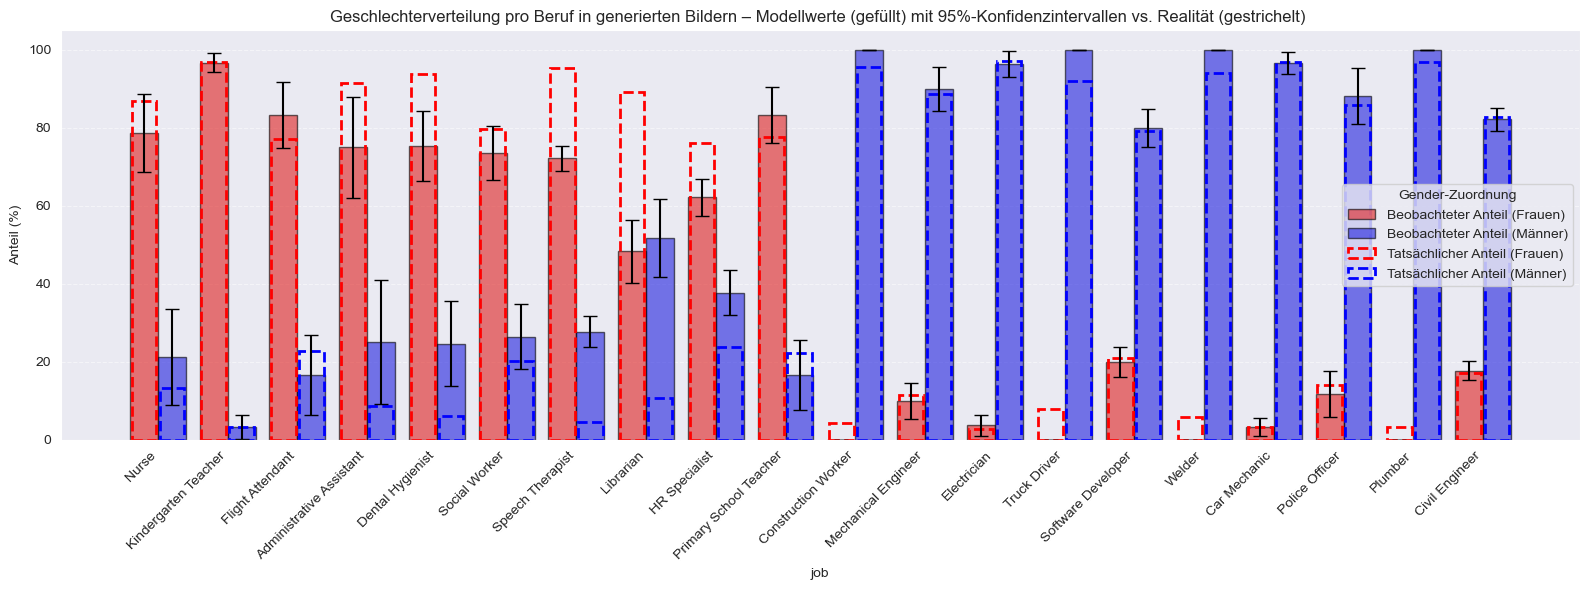

In [20]:
# 1. Definiere Reihenfolge
job_order = [
    "Nurse",
    "Kindergarten Teacher",
    "Flight Attendant",
    "Administrative Assistant",
    "Dental Hygienist",
    "Social Worker",
    "Speech Therapist",
    "Librarian",
    "HR Specialist",
    "Primary School Teacher",
    "Construction Worker",
    "Mechanical Engineer",
    "Electrician",
    "Truck Driver",
    "Software Developer",
    "Welder",
    "Car Mechanic",
    "Police Officer",
    "Plumber",
    "Civil Engineer"
]

# 2. Farbpalette und Geschlechterreihenfolge
palette = {"female": "red", "male": "blue"}
genders = ["female", "male"]
de_labels = {
    "female": "Beobachteter Anteil (Frauen)",
    "male": "Beobachteter Anteil (Männer)",
    "real female": "Tatsächlicher Anteil (Frauen)",
    "real male": "Tatsächlicher Anteil (Männer)"
}

# Sortierung anwenden
plot_df["job"] = pd.Categorical(plot_df["job"], categories=job_order, ordered=True)
plot_df = plot_df.sort_values(["job", "gender"])

# Plot
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=plot_df, x="job", y="percent", hue="gender", palette=palette, edgecolor="black")

# Balken transparenter machen
for patch in ax.patches:
    patch.set_alpha(0.6)

# Fehlerbalken
bar_positions = {}
jobs = plot_df["job"].cat.categories
genders = ["female", "male"]

for i, job in enumerate(jobs):
    for gender in genders:
        row = plot_df[(plot_df["job"] == job) & (plot_df["gender"] == gender)].iloc[0]
        offset = -0.2 if gender == "female" else 0.2
        x = i + offset
        plt.errorbar(x=x, y=row["percent"], yerr=row["ci"], fmt='none', ecolor='black', capsize=5)
        bar_positions[(job, gender)] = x

# Gestrichelte Balken für reale Werte
for i, row in plot_df.iterrows():
    x = bar_positions[(row["job"], row["gender"])]
    plt.bar(
        x, row["real_percent"], width=0.35,
        color="none", edgecolor=palette[row["gender"]],
        linestyle="--", linewidth=2,
        label=f"real {row['gender']}"
    )

# Legende aufräumen und übersetzen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), [de_labels.get(lbl, lbl) for lbl in by_label.keys()], title="Gender-Zuordnung")

# Layout
plt.xticks(ticks=np.arange(len(jobs)), labels=jobs, rotation=45, ha="right")
plt.ylabel("Anteil (%)")
plt.title("Geschlechterverteilung pro Beruf in generierten Bildern – Modellwerte (gefüllt) mit 95%-Konfidenzintervallen vs. Realität (gestrichelt) ")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

filename = f"../plots/IMAGES_Histogram_gender_job_3datasets_plus_real.png"
plt.savefig(filename, dpi=300)

plt.show()

## Vergleich: Beobachtete vs. tatsächliche Genderverteilung pro Beruf je Durchlauf
Dieser Abschnitt visualisiert die extrahierten Gender-Anteile (aus den generierten Bildern) im Vergleich zu den tatsächlichen Anteilen in der Bevölkerung separat je Durchlauf.

In [26]:
df_all["sd_dev_female"] = np.sqrt(df_all["squared_dev_female"])
df_all["sd_dev_male"] = np.sqrt(df_all["squared_dev_male"])

# z-Wert für 95% Konfidenzintervall
z = 1.96
df_all["ci_female_source"] = z * df_all["sd_dev_female"]
df_all["ci_male_source"] = z * df_all["sd_dev_male"]

print(df_all.columns)

Index(['job', 'number_person', 'number_female', 'number_male',
       'percent_female', 'percent_male', 'source', 'tot_percent_female',
       'tot_percent_male', 'squared_dev_female', 'weighted_squared_dev_female',
       'squared_dev_male', 'weighted_squared_dev_male', 'std_female',
       'std_male', 'ci_female', 'ci_male', 'sd_dev_female', 'sd_dev_male',
       'ci_female_source', 'ci_male_source'],
      dtype='object')


In [37]:
df_real = pd.concat([df_female, df_male])
df_real["percent_male"] = 100 - df_real["percent_female"]

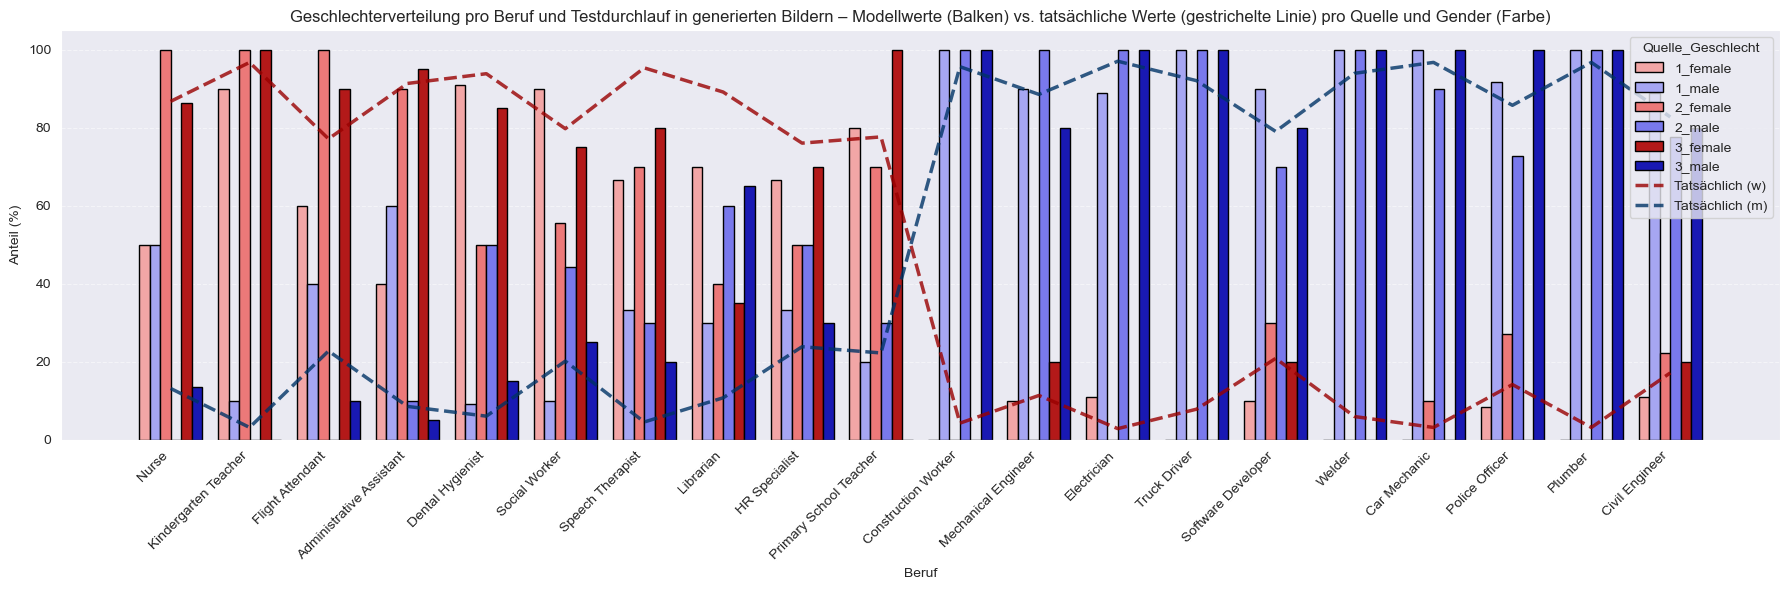

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Vorbereitung ---

# Geschlechter und Farben
palette = {"female": "red", "male": "blue"}
genders = ["female", "male"]
sources = [1, 2, 3]

# Deutsche Legendenbeschriftungen
de_labels = {
    "female": "Beobachteter Anteil (Frauen)",
    "male": "Beobachteter Anteil (Männer)",
    "real female": "Tatsächlicher Anteil (Frauen)",
    "real male": "Tatsächlicher Anteil (Männer)"
}

# Reihenfolge der Berufe
job_order = [
    "Nurse", "Kindergarten Teacher", "Flight Attendant", "Administrative Assistant",
    "Dental Hygienist", "Social Worker", "Speech Therapist", "Librarian",
    "HR Specialist", "Primary School Teacher", "Construction Worker", "Mechanical Engineer",
    "Electrician", "Truck Driver", "Software Developer", "Welder",
    "Car Mechanic", "Police Officer", "Plumber", "Civil Engineer"
]

# 🔄 Daten transformieren in Long-Format: gender & percent
plot_df = df_all.melt(
    id_vars=["job", "source"],
    value_vars=["percent_female", "percent_male"],
    var_name="gender",
    value_name="percent"
)
plot_df["gender"] = plot_df["gender"].str.replace("percent_", "")  # z.B. 'percent_female' -> 'female'

# Kategorie-Reihenfolge festlegen
plot_df["job"] = pd.Categorical(plot_df["job"], categories=job_order, ordered=True)
plot_df = plot_df.sort_values(["job", "source", "gender"])

# ➕ Gruppierung für 6 Balken je Job: kombiniere source und gender
plot_df["source_gender"] = plot_df["source"].astype(str) + "_" + plot_df["gender"]

# Balkenplot mit 6 Balken pro Job
plt.figure(figsize=(18, 6))
ax = sns.barplot(
    data=plot_df,
    x="job", y="percent",
    hue="source_gender",  # ⬅️ ergibt 6 Balken pro Job
    palette=["#FF9999", "#9999FF", "#FF6666", "#6666FF", "#CC0000", "#0000CC"],  # unterschiedliche Farben
    edgecolor="black"
)

# Gestrichelte Linien für reale Werte
# Erstelle real_df wie beschrieben:
real_df = pd.concat([df_female, df_male])
real_df["percent_male"] = 100 - real_df["percent_female"]

# Für jede gender-Linie
for gender, linestyle, color in zip(["female", "male"], ["--", "--"], ["#990000", "#003366"]):
    real = real_df[["job", f"percent_{gender}"]].copy()
    real["job"] = pd.Categorical(real["job"], categories=job_order, ordered=True)
    real = real.sort_values("job")

    # Y-Werte: reale Prozentwerte
    y = real[f"percent_{gender}"].values

    # X-Werte: numerisch (für jede Job-Position)
    x = range(len(job_order))

    # Plotten
    ax.plot(
        x,
        y,
        linestyle=linestyle,
        color=color,
        linewidth=2.5,
        label=f"Tatsächlich ({'w' if gender == 'female' else 'm'})",
        alpha=0.8
    )


# Styling
plt.xticks(rotation=45, ha="right")
plt.ylabel("Anteil (%)")
plt.xlabel("Beruf")
plt.title("Geschlechterverteilung pro Beruf und Testdurchlauf in generierten Bildern – Modellwerte (Balken) vs. tatsächliche Werte (gestrichelte Linie) pro Quelle und Gender (Farbe)")
plt.legend(title="Quelle_Geschlecht", loc="upper right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)

filename = f"../plots/IMAGES_gender_distribution_3sources_vs_real.png"
plt.savefig(filename, dpi=300)

plt.show()
